In [ ]:
import os
import json
import logging
import pandas as pd
from typing import Dict, List
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from bertopic import BERTopic
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
class ModelComparison:
  def __init__(self, input_file="processed_data.json", output_dir="model_comparison"):
    self.input_file = input_file
    self.output_dir = output_dir
    self.viz_dir = os.path.join(output_dir, "visualizations")
    os.makedirs(self.viz_dir, exist_ok=True)
    self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    self.keybert = KeyBERT(model=self.sentence_model)
    
  def load_data(self) -> Dict[str, List[str]]:
    with open(self.input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return {
        'darkweb': df[df['source'] == 'darkweb']['text'].tolist(),
        'reddit': df[df['source'] == 'reddit']['text'].tolist()
    }
    


In [16]:
modelcompare = ModelComparison()
data = modelcompare.load_data()


In [17]:
darkweb_data = data['darkweb']
reddit_data = data['reddit']

In [18]:
def run_BERTopic(texts, n_topics=5):
  if not texts:
    return None, [], [], None, None
  model = BERTopic()
  topics, probs = model.fit_transform(texts)
  return model, topics, probs

In [19]:
# model, topics, probs = run_BERTopic(darkweb_data)

In [ ]:
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(nr_topics="auto")
topics, probs = topic_model.fit_transform(darkweb_data)


embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("model_comparison/best_models/BERTopic_darkweb", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)
vectorizer = topic_model.vectorizer_model
tokenizer = vectorizer.build_tokenizer()
words = vectorizer.get_feature_names_out()
tokens = [tokenizer(doc) for doc in darkweb_data]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.5096610903724429


In [21]:
vectorizer = topic_model.vectorizer_model
tokenizer = vectorizer.build_tokenizer()
words = vectorizer.get_feature_names_out()
tokens = [tokenizer(doc) for doc in darkweb_data]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words_dark = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words_dark, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.5096610903724429


In [22]:
representation_model = KeyBERTInspired()
topic_model = BERTopic(nr_topics="auto",representation_model=representation_model)
topics, probs = topic_model.fit_transform(reddit_data)

embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("model_comparison/best_models/BERTopic_reddit", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

In [23]:
vectorizer = topic_model.vectorizer_model
tokenizer = vectorizer.build_tokenizer()
words = vectorizer.get_feature_names_out()
tokens = [tokenizer(doc) for doc in reddit_data]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words_reddit = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words_reddit, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.6232101023586243


In [31]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model_st = SentenceTransformer("all-MiniLM-L6-v2")

# Embed the topic strings
embeddings_reddit = model_st.encode(topic_words_reddit, normalize_embeddings=True)
embeddings_darkweb = model_st.encode(topic_words_dark, normalize_embeddings=True)

In [36]:
# Compute cosine similarities between each Reddit and Darkweb topic
similarity_matrix = cosine_similarity(embeddings_reddit, embeddings_darkweb)

# For each Reddit topic, find the best-matching Darkweb topic
threshold = 0.5  # Adjust this threshold as needed
common_topics = []
unique_reddit = []
unique_darkweb = set(range(len(embeddings_darkweb)))  # Keep track of unmatched darkweb topics

reddit_topic_ids = list(range(len(embeddings_reddit)))
darkweb_topic_ids = list(range(len(embeddings_darkweb)))

for i, reddit_topic in enumerate(reddit_topic_ids):
    sims = similarity_matrix[i]
    max_sim_idx = np.argmax(sims)
    max_sim_val = sims[max_sim_idx]

    if max_sim_val >= threshold:
        darkweb_topic = darkweb_topic_ids[max_sim_idx]
        common_topics.append((reddit_topic, darkweb_topic, max_sim_val))
        unique_darkweb.discard(darkweb_topic)
    else:
        unique_reddit.append(reddit_topic)


In [37]:
print("Common Topics (Reddit ID, Darkweb ID, Similarity):")
for r, d, sim in common_topics:
    print(f"{r} <--> {d} | Sim: {sim:.2f}")
    print(f"Reddit: {topic_words_reddit[r]}")
    print(f"Darkweb: {topic_words_dark[d]}")
    print("----")

print("\nUnique Reddit Topics:")
for r in unique_reddit:
    print(f"{r}: {topic_words_reddit[r]}")

print("\nUnique Darkweb Topics:")
for d in unique_darkweb:
    print(f"{d}: {topic_words_dark[d]}")


Common Topics (Reddit ID, Darkweb ID, Similarity):
3 <--> 1 | Sim: 0.72
Reddit: ['tor', 'privacy', 'vpn', 'anonymity', 'surveillance', 'protect', 'torbased', 'onionbrowser', 'onion', 'traffic']
Darkweb: ['enforcement', 'privacy', 'analytics', 'google', 'safeguard', 'data', 'security', 'information', 'garante', 'leaked']
----
7 <--> 1 | Sim: 0.74
Reddit: ['privacy', 'privacyrelated', 'privacyguides', 'privacytools', 'privacytoolsio', 'freedom', 'cryptopartybln', 'intersection', 'transparent', 'technology']
Darkweb: ['enforcement', 'privacy', 'analytics', 'google', 'safeguard', 'data', 'security', 'information', 'garante', 'leaked']
----
9 <--> 2 | Sim: 0.76
Reddit: ['pirate', 'domain', 'torrent', 'thepiratebay', 'redirect', 'qbittorrent', 'tpb', 'website', 'bay', 'btguard']
Darkweb: ['proxy', 'piratebay', 'pirate', 'haproxy', 'thepiratebay', 'cloudflare', 'bay', 'load', 'website', 'cache']
----
11 <--> 13 | Sim: 0.64
Reddit: ['linux', 'linux4noobs', 'linuxmemes', 'gnu', 'linuxquestions'

## Model comparison

In [115]:
from gensim.models.ldamodel import LdaModel
from gensim.models import Nmf, LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [116]:
new_data = [list(str.split()) for str in reddit_data]
common_dictionary = Dictionary(new_data)
common_corpus = [common_dictionary.doc2bow(text) for text in new_data]
lda = LdaModel(common_corpus, id2word=common_dictionary)
cv = CoherenceModel(model=lda, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v')
u_mass = CoherenceModel(model=lda, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
c_uci = CoherenceModel(model=lda, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_uci')

cv_score = cv.get_coherence()  # get coherence value
u_mass_score = u_mass.get_coherence()
c_uci_score = c_uci.get_coherence()
print(f"Reddit LDA:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")

nmf = Nmf(common_corpus, id2word=common_dictionary)
cv = CoherenceModel(model=nmf, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v')
u_mass = CoherenceModel(model=nmf, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
c_uci = CoherenceModel(model=nmf, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_uci')

cv_score = cv.get_coherence()  # get coherence value
u_mass_score = u_mass.get_coherence()
c_uci_score = c_uci.get_coherence()
print(f"Reddit NMF:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")

lsi = LsiModel(common_corpus, id2word=common_dictionary)
cv = CoherenceModel(model=lsi, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v')
u_mass = CoherenceModel(model=lsi, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
c_uci = CoherenceModel(model=lsi, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_uci')

cv_score = cv.get_coherence()  # get coherence value
u_mass_score = u_mass.get_coherence()
c_uci_score = c_uci.get_coherence()
print(f"Reddit LSI:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")


Reddit LDA:
 c_v : 0.4666475235834685
 u_mass : -6.204573492932857 
 pmi : -9.50937364903869 
Reddit NMF:
 c_v : 0.6300982902462886
 u_mass : -5.332711584099025 
 pmi : -9.030465684369595 
Reddit LSI:
 c_v : 0.43941017995398274
 u_mass : -15.784981449828477 
 pmi : -7.577258073502334 


In [117]:
new_data = [list(str.split()) for str in darkweb_data]
common_dictionary = Dictionary(new_data)
common_corpus = [common_dictionary.doc2bow(text) for text in new_data]
lda = LdaModel(common_corpus, id2word=common_dictionary)
cv = CoherenceModel(model=lda, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v')
u_mass = CoherenceModel(model=lda, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
c_uci = CoherenceModel(model=lda, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_uci')

cv_score = cv.get_coherence()  # get coherence value
u_mass_score = u_mass.get_coherence()
c_uci_score = c_uci.get_coherence()
print(f"Darkweb LDA:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")

nmf = Nmf(common_corpus, id2word=common_dictionary)
cv = CoherenceModel(model=nmf, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v')
u_mass = CoherenceModel(model=nmf, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
c_uci = CoherenceModel(model=nmf, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_uci')

cv_score = cv.get_coherence()  # get coherence value
u_mass_score = u_mass.get_coherence()
c_uci_score = c_uci.get_coherence()
print(f"Darkweb NMF:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")

lsi = LsiModel(common_corpus, id2word=common_dictionary)
cv = CoherenceModel(model=lsi, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v')
u_mass = CoherenceModel(model=lsi, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
c_uci = CoherenceModel(model=lsi, texts=new_data, corpus=common_corpus, dictionary=common_dictionary, coherence='c_uci')

cv_score = cv.get_coherence()  # get coherence value
u_mass_score = u_mass.get_coherence()
c_uci_score = c_uci.get_coherence()
print(f"Reddit LSI:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")


Darkweb LDA:
 c_v : 0.31228945276966924
 u_mass : -2.9716530382097504 
 pmi : -4.055214631782007 
Darkweb NMF:
 c_v : 0.4523762118167143
 u_mass : -3.275117256224011 
 pmi : -5.637451804157724 
Reddit LSI:
 c_v : 0.4236290078633918
 u_mass : -7.043392617985054 
 pmi : -9.687420064333605 


In [123]:
representation_model = KeyBERTInspired()
topic_model = BERTopic(nr_topics="auto", representation_model=representation_model)
topics, probs = topic_model.fit_transform(darkweb_data)

vectorizer = topic_model.vectorizer_model
tokenizer = vectorizer.build_tokenizer()
words = vectorizer.get_feature_names_out()
tokens = [tokenizer(doc) for doc in darkweb_data]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
cv = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
cv_score = cv.get_coherence()
u_mass = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='u_mass')
u_mass_score = u_mass.get_coherence()

c_uci
c_uci = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_uci')
c_uci_score = u_mass.get_coherence()
print(f"Darkweb BERTopic:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")


Darkweb BERTopic:
 c_v : 0.49210756883612383
 u_mass : -4.995008254002581 
 pmi : -4.995008254002581 


In [122]:
representation_model = KeyBERTInspired()
topic_model = BERTopic(nr_topics="auto", representation_model=representation_model)
topics, probs = topic_model.fit_transform(reddit_data)

vectorizer = topic_model.vectorizer_model
tokenizer = vectorizer.build_tokenizer()
words = vectorizer.get_feature_names_out()
tokens = [tokenizer(doc) for doc in reddit_data]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
cv = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
cv_score = cv.get_coherence()
u_mass = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='u_mass')
u_mass_score = u_mass.get_coherence()

c_uci
c_uci = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_uci')
c_uci_score = u_mass.get_coherence()
print(f"Reddit BERTopic:\n c_v : {cv_score}\n u_mass : {u_mass_score} \n pmi : {c_uci_score} ")


Reddit BERTopic:
 c_v : 0.5910465170259444
 u_mass : -5.47825871655975 
 pmi : -5.47825871655975 


In [124]:
representation_model = KeyBERTInspired()
reddit_model = BERTopic(nr_topics="auto", representation_model=representation_model)
topics, probs = reddit_model.fit_transform(reddit_data)
dark_model = BERTopic(nr_topics="auto", representation_model=representation_model)
topics, probs = dark_model.fit_transform(darkweb_data)

In [125]:
dark_model.visualize_topics()

In [126]:
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(dark_model.topic_embeddings_, reddit_model.topic_embeddings_)

In [127]:
sim_matrix

array([[0.44402753, 0.63715597, 0.64710454, 0.51495025, 0.33687722,
        0.23316122, 0.42423834, 0.52081382, 0.31858872, 0.21070645,
        0.32971117],
       [0.33627644, 0.60072495, 0.69197445, 0.50066786, 0.31734236,
        0.22302226, 0.40720538, 0.51391298, 0.3210179 , 0.26350798,
        0.35702205],
       [0.51900454, 0.60084488, 0.59349397, 0.3841421 , 0.45311535,
        0.14360876, 0.38999826, 0.2209788 , 0.32674145, 0.11691048,
        0.28519474],
       [0.41360449, 0.61775673, 0.63095094, 0.44870163, 0.26446883,
        0.22120608, 0.37710886, 0.34989477, 0.36755392, 0.25305744,
        0.29437423],
       [0.54951212, 0.66228017, 0.41739049, 0.30447264, 0.34098715,
        0.13370723, 0.31238388, 0.11652744, 0.35241738, 0.17606053,
        0.32240827],
       [0.45641634, 0.54568825, 0.5759834 , 0.24938819, 0.38166351,
        0.09823409, 0.36326627, 0.17525912, 0.35670299, 0.134023  ,
        0.29025876],
       [0.33567613, 0.41758506, 0.41764086, 0.37137592, 0.

In [162]:
topic = 3
most_similar_topic = np.argmax(sim_matrix[topic + 1])-1
most_similar_topic_score = np.max(sim_matrix[topic + 1])

In [163]:
sim_matrix[4]

array([0.54951212, 0.66228017, 0.41739049, 0.30447264, 0.34098715,
       0.13370723, 0.31238388, 0.11652744, 0.35241738, 0.17606053,
       0.32240827])

In [164]:
most_similar_topic_score

0.6622801679880336

In [165]:
dark_topics = dark_model.get_topics()
reddit_topics = reddit_model.get_topics()


In [182]:
similar_topics = []
not_matched_topics = []
threshold = 0.8
for topic in dark_topics.keys():
  most_similar_topic = np.argmax(sim_matrix[topic + 1]) -1
  most_similar_topic_score = np.max(sim_matrix[topic + 1])
  if most_similar_topic >= threshold:
    similar_topics.append([topic, most_similar_topic])
  else:
    not_matched_topics.append(topic)

In [227]:
topic_labels_dark = dark_model.generate_topic_labels(nr_words=2, separator=", ", topic_prefix=False)
topic_labels_reddit = reddit_model.generate_topic_labels(nr_words=2, separator=", ", topic_prefix=False)

In [251]:
dark_model.get_representative_docs(3)

['written emma roth published june 2022 google agreed pay 100 million illinois resident settle class-action lawsuit one facial recognition feature google photo via gizmodo complaint alleges google face grouping tool automatically identifies face photo video uploaded photo violates illinois biometric information privacy act bipa introduced 2008 bipa bar company collecting storing sort biometric data including retina iris scan fingerprint voiceprint scan hand face geometry without making individual aware writing collecting kind data well long plan storing google direct violation law complaint claim allegedly collect analyzes person facial structure connection face grouping feature without providing notice obtaining informed written consent publishing data retention policy google agreed 100 million payout result class-action suit required provide user notice face grouping feature illinois resident appeared photo video google photo may 1st 2015 april 25th 2022 september 24th 2022 submit cl

In [228]:
frequency_dark = {}
for topic in dark_topics.keys():
  topic_freq = dark_model.get_topic_freq(topic)
  frequency_dark[topic_labels_dark[topic]] = topic_freq

frequency_reddit = {}
for topic in reddit_topics.keys():
  topic_freq = reddit_model.get_topic_freq(topic)
  frequency_reddit[topic_labels_reddit[topic]] = topic_freq

In [233]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})
# Step 1: Sort the dictionary by value (descending)
top_reddit = dict(sorted(frequency_reddit.items(), key=lambda x: x[1], reverse=True)[:5])
top_darknet = dict(sorted(frequency_dark.items(), key=lambda x: x[1], reverse=True)[:5])

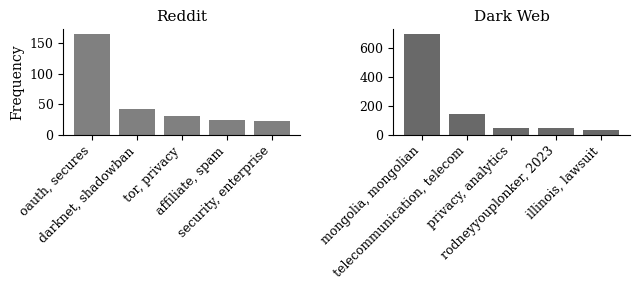

In [234]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))  # Width fits 1-column IEEE/ACM page
fig.subplots_adjust(wspace=0.4)  # space between plots

# Plot Reddit
axes[0].bar(top_reddit.keys(), top_reddit.values(), color='gray')
axes[0].set_title('Reddit')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(top_reddit.keys(), rotation=45, ha='right')

# Plot Darknet
axes[1].bar(top_darknet.keys(), top_darknet.values(), color='dimgray')
axes[1].set_title('Dark Web')
axes[1].set_xticklabels(top_darknet.keys(), rotation=45, ha='right')

# Remove top/right borders for cleaner look
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Tight layout for better spacing
plt.tight_layout()

In [184]:
not_matched_topics

[1, 3, 6, 7, 8, 9, 10, 12, 13, 24]

In [235]:
similarity_matrix = np.random.rand(10, 10)  # Reddit x Darknet similarity
darknet_topics = [f"D{i}: topic terms..." for i in range(sim_matrix.shape[0])]
reddit_topics = [f"R{j}: topic terms..." for j in range(sim_matrix.shape[1])]


In [245]:
reddit_max = np.max(similarity_matrix, axis=1)
reddit_dissimilar = sorted(zip(topic_labels_reddit, reddit_max), key=lambda x: x[1] + 1)[:5]

# 2. For Darknet topics: find max similarity across all Reddit topics
darknet_max = np.max(similarity_matrix, axis=0)
darknet_dissimilar = sorted(zip(topic_labels_dark, darknet_max), key=lambda x: x[1] + 1)[:5]

# 3. Create tables
reddit_df = pd.DataFrame(reddit_dissimilar, columns=["Reddit Topic", "Max Cosine Similarity"])
darknet_df = pd.DataFrame(darknet_dissimilar, columns=["Darknet Topic", "Max Cosine Similarity"])

# Round similarity values
reddit_df["Max Cosine Similarity"] = reddit_df["Max Cosine Similarity"].round(3)
darknet_df["Max Cosine Similarity"] = darknet_df["Max Cosine Similarity"].round(3)

# Display
print("Most Dissimilar Reddit Topics (no close match on Darknet):")
print(reddit_df.to_string(index=False))
print("\nMost Dissimilar Darknet Topics (no close match on Reddit):")
print(darknet_df.to_string(index=False))

Most Dissimilar Reddit Topics (no close match on Darknet):
        Reddit Topic  Max Cosine Similarity
security, enterprise                  0.718
      oauth, secures                  0.772
         tail, linux                  0.838
        tor, privacy                  0.924
  darknet, shadowban                  0.960

Most Dissimilar Darknet Topics (no close match on Reddit):
          Darknet Topic  Max Cosine Similarity
      illinois, lawsuit                  0.614
    mongolia, mongolian                  0.825
             2025, 2024                  0.877
copyright, infringement                  0.887
     privacy, analytics                  0.917


In [249]:
import numpy as np

# Given:
# subreddit_topics: list of subreddit topic labels
# darkweb_topics: list of dark web forum topic labels
# cos_sim: cosine similarity matrix of shape (len(subreddit_topics), len(darkweb_topics))

# Flatten and sort the similarity scores in descending order
flat_indices = np.argsort(sim_matrix, axis=None)[::-1]

# Extract the top matching pairs
top_pairs = [(idx // sim_matrix.shape[1], idx % sim_matrix.shape[1], sim_matrix.flat[idx]) for idx in flat_indices]

# Example: output top k pairs
k = 10
for i, (sub_idx, dark_idx, sim) in enumerate(top_pairs[:k]):
    print(f"{i+1}. '{topic_labels_dark[sub_idx]}' and '{topic_labels_reddit[dark_idx]}' with similarity {sim:.3f}")


1. 'blocklists, p2p' and 'tor, privacy' with similarity 0.692
2. 'linux, distro' and 'linux, linux4noobs' with similarity 0.678
3. 'illinois, lawsuit' and 'darknet, shadowban' with similarity 0.662
4. 'mongolia, mongolian' and 'tor, privacy' with similarity 0.647
5. 'surveillance, police' and 'darknet, shadowban' with similarity 0.641
6. 'mongolia, mongolian' and 'darknet, shadowban' with similarity 0.637
7. 'rodneyyouplonker, 2023' and 'tor, privacy' with similarity 0.631
8. 'snooping, platform' and 'darknet, shadowban' with similarity 0.625
9. 'rodneyyouplonker, 2023' and 'darknet, shadowban' with similarity 0.618
10. 'privacy, analytics' and 'darknet, shadowban' with similarity 0.601


In [253]:
import numpy as np

# cos_sim shape: (num_subreddit_topics, num_darkweb_topics)
max_sim_per_darkweb_topic = sim_matrix.max(axis=1)  # max similarity for each darkweb topic

# Get darkweb topics with lowest max similarity to any subreddit topic
dissimilar_darkweb_indices = np.argsort(max_sim_per_darkweb_topic)  # ascending order

print("Darkweb topics least discussed on Reddit:")
for idx in dissimilar_darkweb_indices[:5]:  # top 5 least similar
    print(f"'{topic_labels_dark[idx]}' with max similarity {max_sim_per_darkweb_topic[idx]:.3f}")


Darkweb topics least discussed on Reddit:
'kenya, passport' with max similarity 0.277
'seedbox, seedboxes' with max similarity 0.301
'ban, canada' with max similarity 0.303
'review, site' with max similarity 0.333
'tracker, tracking' with max similarity 0.356


In [255]:
max_sim_per_subreddit_topic = sim_matrix.max(axis=0)  # max similarity for each subreddit topic

# Get subreddit topics with lowest max similarity to any darkweb topic
dissimilar_subreddit_indices = np.argsort(max_sim_per_subreddit_topic)  # ascending order

print("Reddit topics least discussed on Darkweb:")
for idx in dissimilar_subreddit_indices[:5]:  # top 5 least similar
    print(f"'{topic_labels_reddit[idx]}' with max similarity {max_sim_per_subreddit_topic[idx]:.3f}")


Reddit topics least discussed on Darkweb:
'doom, het' with max similarity 0.326
'qubes, qubesos' with max similarity 0.437
'security, enterprise' with max similarity 0.453
'malware, antivirus' with max similarity 0.462
'affiliate, spam' with max similarity 0.515


In [ ]:
topic